# Latent Dirichlet Allocation with Python

## Prerequisites

__Experience with the specific topic:__ Intermediate

__Professional experience:__ None

Previous knowledge of traditional natural langauge processing techniques, especially text preprocessing and the math behind topic model algorithms, is helpful, but not assumed. This tutorial will cover the basics of the entire topic modeling process in Python with code and theoretical explanations of the processes being used. To follow the examples, the reader should be familiar with coding in Python, especially using the data manipulation package Pandas and vectorized operations. Knowledge of Bayesian and graphical models is also helpful, but not necessary to follow along. All code for this tutorial was written using Python 3.

The following Python packages will be used in this demonstration:
- Pandas
- NLTK
- Gensim
- pyLDAvis
- Matplotlib

As well as the following libraries from the Python Standard Library:
- String
- Collections

### Introduction to Topic Modeling and Latent Dirichlet Allocation

#### Objectives
At the end of this tutorial, the reader can expec to know how to:
- Understand the basic theory behind topic modeling (especially LDA models)
- Understand and perform basic text preprocessing in Python
- Know how to implement an LDA model in Python and understand its outputs
- Interpret and visualize an LDA model using Python packages and custom visualizations

An important thing to note is that, while this tutorial will cover the basics of topic modeling and NLP theory, the focus will be on the uses of this kind of analysis. This tutorial will focus on a specific use case of LDA models to disposition blocks of segmented text to see how different groups of respondents are reacting and what they're discussing. This example will use sample Yelp review data.

#### What is it and how does it work?
Topic modeling, generally, is a statistical natural language processing (NLP) task that focuses on inferring hidden, otherwise known as latent, topics in a group of texts. A topic, in this case, is a series of related words that co-occur together across a number of different documents and are inferred to be related to each other. A good example would be ESPN articles discussing sports. Documents containing the words "stick", "puck", and "goalie" could be inferred to be, at least in part, about hockey, while documents that contain "touchdown", "yard", and "ball" could be inferred to be about football. One thing to note here is that the word "ball" could be ambiguous, given that soccer, basketball, baseball, and other sports all use the word "ball" regularly. This is important because topic modeling looks for words that are uniquely associated with each other, and because each document can contain more than one topic.

![Demonstration of LDA procedure](LDA-concept.png)

That is actually a major strength of topic modeling, given that text clustering also tries to separate documents. Doucments are not exclusively associated with single topics, and one document could be associated with many different topics. This relationship, depending on the topic modeling approach, is typically represented as a probability or likelihood score.

Latent Dirichlet Allocation (LDA) is a particular topic modeling algorithm that's currently currently popular. Unlike some topic modeling methods like latent semantic analysis, which uses a matrix decomposition to drive its processes, LDA is a generative, Bayesian process that uses statistical distributions to generate a model. In fact, the name Latent Dirichlet Allocation is a reference to the specific probability distribution, the Dirichlet distribution, that is used to generate the model. The Dirichlet distribution was chosen because it does a good job of modeling the sparse relationship between individual words and documents. LDA is a big, math-heavy topic, that won't be covered in depth here. Those interested in learning more are encouraged to check the [LDA Wikipedia page](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) or check out the work of David Blei, who has authored many of the best papers on the subject.

_Note:_ From here on out we'll be referring specifically to LDA models instead of topic models generally.

#### Business Uses
LDA models have a number of business uses for understanding and using text data more effectively. Here are a few possible use cases:
- Finding latent topics in a large group of documents or articles
- Tracking changes in discussion over time using [dynamic LDA](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2006a.pdf)
- Dispositioning text based on market segments (a use case that this article will cover in more depth)
- Using per-document topic relationships as features in predictive models

### Step 1: Load Python Packages

We'll begin our analysis by loading the relevant Python packages. We'll be using sevearl different packages to handle different parts of the model training and analysis methodology. __Pandas__ will be used for loading the data and doing basic cleaning to prepare the data for text preprocessing, and then again later to segment the data. The Python __Natural Language Toolkit (NLTK)__, as well as __string__,  will be used to do the basic text preprocessing necessary to get the data ready for analysis. __Gensim__ wil be used to create the NLP text structures that the model can interpret, as well as do the LDA training itself and some of the analysis. __Collections__, __matplotlib__, and __pyLDAvis__ will be used to visualize the model outputs.

In [1]:
#import necessary packages
import pandas as pd
import gensim as gs
import pyLDAvis
import pyLDAvis.gensim
import string

from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

%matplotlib inline
pyLDAvis.enable_notebook()

C:\Users\jonat\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Step 2: Load and Clean Data

As stated above, the data for this tutorial is a set of 10,000 Yelp reviews. The original, much larger, dataset that this is a subset of can be found [here](https://www.yelp.com/dataset/challenge)). In addition to the text, there's an anonymized business ID, the date of the review, a unique ID for the review itself, a review type, unique user ID, and several counters for how cool, useful, or funny the data is. Here's a sample:

In [2]:
#let's look at the data
data = pd.read_csv('yelp.csv')
data.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


Despite this being a rich dataset that could be mined many different ways, we're only really interested in the number of stars and the text itself. The rest of the columns will be dropped.

In [3]:
data.drop(labels=['business_id', 'date','review_id', 'type', 'user_id', 'cool',
                  'useful', 'funny'], axis=1, inplace=True)
data.head(1)

,stars,text
0,5,My wife took me here on my birthday for breakf...


### Step 3: Text Preprocessing

Now that the data is loaded, before it can be used in an LDA model it has to be cleaned and prepared, a process called 'text preprocessing'. To get a sense of why, let's look at a sample review:

In [4]:
data['text'][4]

'General Manager Scott Petello is a good egg!!! Not to go into detail, but let me assure you if you have any issues (albeit rare) speak with Scott and treat the guy with some respect as you state your case and I\'d be surprised if you don\'t walk out totally satisfied as I just did. Like I always say..... "Mistakes are inevitable, it\'s how we recover from them that is important"!!!\r\n\r\nThanks to Scott and his awesome staff. You\'ve got a customer for life!! .......... :^)'

It's a bit of a mess! There's a variety of punctuation (including what appears to be emojis), line breaks, and other things that will make analyzing this review difficult. Making this text friendlier for the LDA algorithm is a key step.

This involves several steps which are performed with the help of __string__ and the __NLTK__ packages:
- _Removing line breaks:_ The review above, and a number of others, have line breaks that are unhelpful. They need to be removed.
- _Removing punctuation:_ Punctuation can be difficult to interpret, as well as being used in a number of different ways (including emoticons and emojis) that are not helpful. It's typically best to remove it.
- _Tokenizing the document:_ This is the process of convert the single string that constitutes the document into a list of individual words. This is helpful for the next two steps, as well as critical for creating a dictionary and bag of words, which will be covered in the next step.
- _Removing stopwords:_ Not all words in the English language convey meaning. A large number of words are essentially structural and help make language flow. Examples are words like "the", "a", "an", "or" and many others. These are examples of "stop words", and removing them increase model effectiveness. These structural words are some of the most common in the English language and will have a high rate of co-occurance with almost all of the words we're interested in. Removing them helps increase the LDA model effectiveness.
- _Lemmatizing:_ This step deals with variations of the same word. Some words, verbs especially, have slightly different versions while meaning essentially the same thing. "Run", "ran", and "running" all carry the same content meaning. Lemmatizing reduces words to their base forms to help make topics more coherent.

All these functions have been packaged together in a text_preprocessor function using vectorized Pandas operations that work in place on the input dataframe.

In [5]:
def text_preprocessor(dataframe, text_column):
    """Takes in a Pandas dataframe column or Series of texts and preprocesses them for model building."""
    #set up the NLP variables needed for preprocessing
    stop = list(stopwords.words('english'))
    stop.extend(['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])

    punctuation = list(string.punctuation)
    punctuation.extend(['1','2','3','4','5','6','7','8','9','0'])

    letters = list(string.ascii_lowercase)
    
    #remove the line breaks from each of the reviews
    dataframe[text_column] = dataframe[text_column].apply(lambda x: ' '.join(x.splitlines()))
    
    #remove punctuation
    dataframe[text_column] = dataframe[text_column].apply(lambda x: ''.join(char for char in x if char not in punctuation))

    #tokenize the documents
    dataframe[text_column] = dataframe[text_column].apply(lambda x: word_tokenize(x.lower()))
    
    #remove stopwords
    dataframe[text_column] = dataframe[text_column].apply(lambda x: [i for i in x if i not in stop])

    #lemmatize the results
    dataframe[text_column] = dataframe[text_column].apply(lambda x: [WordNetLemmatizer().lemmatize(i) for i in x])
    
text_preprocessor(data, 'text')
data['text'][4][0:10]

['general',
 'manager',
 'scott',
 'petello',
 'good',
 'egg',
 'go',
 'detail',
 'let',
 'assure']

If we look at that same review from before, we can see that it's now very different. Instead of one string, it's a reduced list of words that is ideal for the LDA modeling process. (Note that the list presented is an excerpt from that review and is not representative of the entire word vector for that document.)

### Step 4: Building the Dictionary and Corpus

Now that each of the documents that we're working with has been converted to a suitable form, a dictionary and corpus can be built from it. This process is done using the __gensim__ package. A dictionary in NLP terms is the set of all words from all documents. This is represented as a Python dictionary of all distinct words from all the documents, along with an index value for reference.

In [8]:
#build a total dictionary of all words in all documents
dictionary = corpora.Dictionary(data.text)
dict(list(dictionary.token2id.items())[0:10])

{'absolute': 0,
 'absolutely': 1,
 'amazing': 2,
 'anyway': 3,
 'arrived': 4,
 'back': 5,
 'best': 6,
 'better': 7,
 'birthday': 8,
 'blend': 9}

Next to be created is the corpus. In this case, the corpus is called a "bag of words", which represents each document as a list of tuples, where the first element is the word index from the dictionary (above) and an incrementer showing the number of times that word appears in that document. This is stucture that the LDA model will iterate over and is the final component we need to create the model.

One drawback to the "bag of words" structure is that it doesn't capture context. Whereas recurrent neural networks can take in words in order, LDA models only operate on the count of words in each document with no regard for the specific location of that word in the given document. This doesn't negate the usefulness of LDA models, but is a factor that must be kept in mind when interpreting LDA model outputs.

In [14]:
#build a per-document numerical representation of the dataset
corpus = [dictionary.doc2bow(doc) for doc in data.text]
corpus[4]

[(18, 1),
 (28, 1),
 (34, 1),
 (70, 1),
 (76, 1),
 (90, 1),
 (91, 1),
 (99, 1),
 (167, 1),
 (185, 1),
 (186, 1),
 (187, 1),
 (188, 1),
 (189, 1),
 (190, 1),
 (191, 1),
 (192, 1),
 (193, 1),
 (194, 1),
 (195, 1),
 (196, 1),
 (197, 1),
 (198, 1),
 (199, 1),
 (200, 1),
 (201, 1),
 (202, 1),
 (203, 1),
 (204, 1),
 (205, 3),
 (206, 1),
 (207, 1),
 (208, 1),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1)]

### Step 5: Training the LDA Model

Now that all the necessary elements have been created, the LDA model can be built. This is also done using the __gensim__ package. LDA models have a number of different tuning knobs that can be turned, but the most important is "k", the number of topics to infer. Selecting a correct value for "k", like selecting the proper number of clusters for a K-Means algorithm, can be a tricky process and there's no one best methodology. One method is check topic results by eye to see if they make sense.

Another method, the one which will be employed today, is to use coherence scores. Coherence scores are a way of measuring whether topics are internally consistent, and there's a number of different metrics with which to measure it. In this case, a metric known as ["UMass"](http://dirichlet.net/pdf/mimno11optimizing.pdf) will be used (primarily for speed).

Below is a method that will calculate a number of different coherence values for different values of "k" for LDA models, along with a quick visualization that'll plot the coherence value.

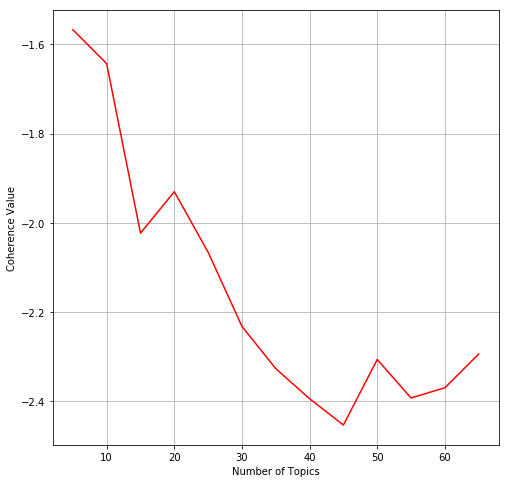

In [16]:
def compute_best_model(dictionary, corpus, texts, start=1, stop=21, increment=2, passes=20, 
                           iterations=20, workers=3, visualize=True):
    """Computes model coherence for a variety of LDA models and returns the model with highest coherence.
    also has optional visualization"""
    model_list = []
    coherence_list = []
    
    #compute the models
    for i in range(start, stop, increment):
        model = models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, num_topics=i, 
                                                 passes=passes, iterations=iterations, workers=workers)
        coherence = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        model_list.append(model)
        coherence_list.append(coherence.get_coherence())
    
    #find the best model from the computed models
    best_model = model_list[coherence_list.index(max(coherence_list))]
    
    #optional visualization of all topics
    if visualize == True:
        plt.figure(figsize=(8,8))
        plt.plot(range(start, stop, increment), coherence_list, color='r')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Value')
        plt.grid()
        
    return best_model

ldamodel = compute_best_model(dictionary=dictionary, corpus=corpus, texts=data.text, start=5, stop=70, 
                              increment=5, visualize=True)

The chart shows that there's a pretty steep decrease in the coherence metric (larger is better) as the number of topics increases, so we'll go with 10 topics for this particular model, and use that for our analysis and visualizations.

LDA models have a number of other tuning parameters, some of which relate to the shape of the Dirichlet prior that is used for the model and can affect per-document word relationships and per-topic word relationships. Other parameters (such as iteration, passes, and workers) affect how many times the algorithm is run over the data and how much computing power is dedicated to the task. The __gensim__ documents for [LdaMulticore](https://radimrehurek.com/gensim/models/ldamulticore.html) are detailed and a great resource for this.

_Note:_ The code above uses the __gensim LdaMulticore__ LDA model. This is very similar to the regular __gensim__ LDA model, but has an additional parameter, workers, which allows the user to run the model across multiple CPU cores with workers determining the number of cores to be used. This generally speeds up processing.

### Step 6: Analyzing and Visualizing the Outputs

Now that an LDA model has been trained, there's a number of different things that can be done with it. The trained LDA model contains the topic-word associations as well as the document-topic associations, both of which can be accessed using model methods. __LdaMulticore.print_topics()__ will show all the computed topics, along with the words most closely associated with each topic. The similar method __show_topics()__ can be used to more easily parse the words. An example function written to parse this and pull out a list of the top 5 words for every topic is below:

In [39]:
def get_top_terms(model, num_words=5):
    """Takes in the .show_topics() method and creates a list of top 5 words for each topic and a list of topics"""
    topics = []
    topic_words = []

    for i in model.show_topics(num_topics=100, num_words=num_words, formatted=False):
        topics.append('Topic %s' % i[0])
        temp = []

        for j in i[1]:
            temp.append(j[0])
        topic_words.append(''.join(x for x in str(temp) if x not in "[']"))

    return topics, topic_words

topics, top_words = get_top_terms(ldamodel)
print(topics[0:10])
top_words[0:10]

['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4']


['like, place, would, time, u',
 'store, great, like, place, get',
 'food, good, place, great, like',
 'place, food, good, great, time',
 'get, like, pizza, im, coffee']

Iterating through __LdaMulticore.get_document_topics()__ will show which documents are associated with which of the computed topics. Below is a function that takes the document topics and graphs the based on how commonly each topic appears in the total group of documents. The __get_top_terms__ function defined above is used to replace the topic number on the axis with the top 5 words for each topic.

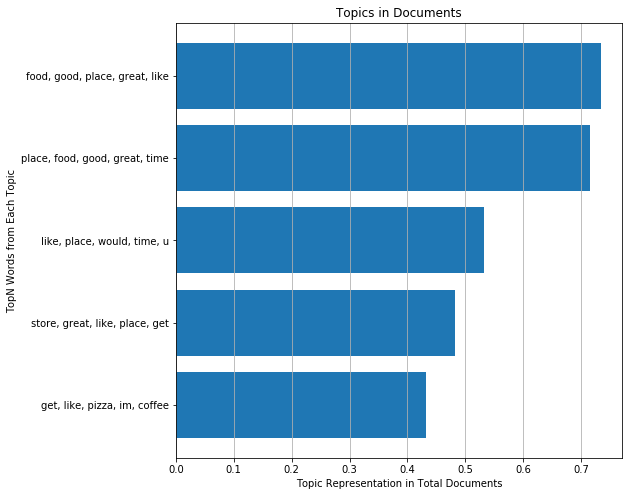

In [42]:
#create dictionary to show outputs of each topic on a bar graph
def graph_topics(model, corpus, documents, normalize=False, num_words=5, figsize=(8,8)):
    """Visualizes the top represented topics in the corpus."""
    topic_counter = {}
    joined = {}
    
    topics, top_words = get_top_terms(model)
    for i in range(len(topics)):
        a = {topics[i]: str(top_words[i])}
        joined.update(a)

    #topic distribution by document
    for i in range(len(documents)):
        for topic, percent in model.get_document_topics(corpus)[i]:
            topic_key = "Topic %s" % topic
            topic_counter[topic_key]  = topic_counter.get(topic_key, 0) + 1
    
    #remap the keys to the topn words from each topic
    topic_counter = dict((joined[key], value) for (key, value) in topic_counter.items())
    
    #choose whether to display by count in # of documents or by % of corpus
    if normalize == True:
        for k, v in topic_counter.items():
            topic_counter[k] = topic_counter[k] / float(len(documents))
    
    #sort the dictionary for better output
    topic_counter = OrderedDict(sorted(topic_counter.items(), key=lambda x: x[1]))
    
    #visualize the results
    plt.figure(figsize=figsize)
    plt.barh(range(len(topic_counter)), list(topic_counter.values()), align='center')
    plt.yticks(range(len(topic_counter)), list(topic_counter.keys()))
    plt.xlabel('Topic Representation in Total Documents')
    plt.ylabel('TopN Words from Each Topic')
    plt.title('Topics in Documents')
    plt.grid(axis='x')
    
graph_topics(model=ldamodel, corpus=corpus, documents=data.text, normalize=True)

This is a great tool for dispositioning a group of comments, like Yelp reviews, and understand what people are talking about. This will be especially useful once the documents are segmented based based on some criteria, in this case the number of stars. We'll break down our original group of documents into people who rate restuarants as good, mediocre, or bad. Based on that segmentation, separate LDA models will be trained on each segment of documents and then visualized so that the difference in what people are talking about can be seen more easily. This is also where keeping the processed texts in the Pandas dataframe comes in useful: it's easy to filter now!

In [59]:
good = data[data.stars == 5]
mediocre = data[(data.stars > 2) & (data.stars < 5)]
bad = data[data.stars < 3]

good_dict = corpora.Dictionary(good.text)
mediocre_dict = corpora.Dictionary(mediocre.text)
bad_dict = corpora.Dictionary(bad.text)

good_corp = [good_dict.doc2bow(doc) for doc in good.text]
mediocre_corp = [mediocre_dict.doc2bow(doc) for doc in mediocre.text]
bad_corp = [bad_dict.doc2bow(doc) for doc in bad.text]

good_model = models.ldamulticore.LdaMulticore(good_corp, id2word=good_dict, num_topics=10, 
                                              passes=10, iterations=10, workers=3)
mediocre_model = models.ldamulticore.LdaMulticore(mediocre_corp, id2word=mediocre_dict, num_topics=10, 
                                                  passes=10, iterations=10, workers=3)
bad_model = models.ldamulticore.LdaMulticore(bad_corp, id2word=bad_dict, num_topics=10, 
                                             passes=10, iterations=10, workers=3)

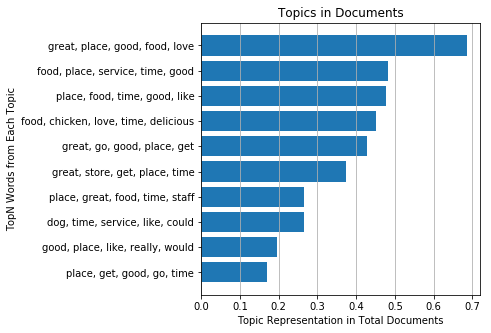

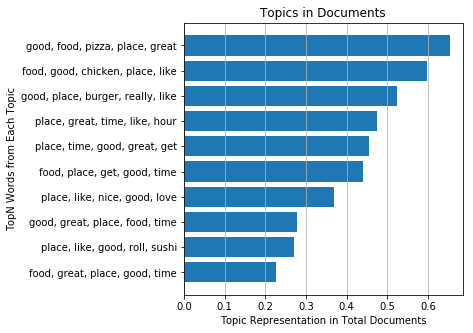

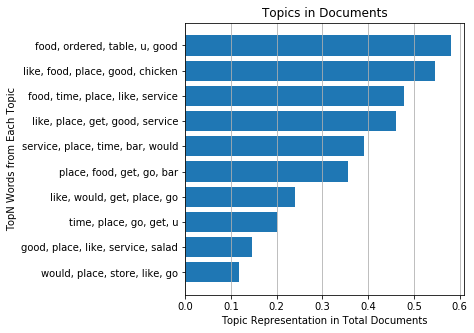

In [60]:
graph_topics(model=good_model, corpus=good_corp, documents=good.text,normalize=True, figsize=(5,5))
graph_topics(model=mediocre_model, corpus=mediocre_corp, documents=mediocre.text, normalize=True, figsize=(5,5))
graph_topics(model=bad_model, corpus=bad_corp, documents=bad.text, normalize=True, figsize=(5,5))

Voila! We now have trained models for each of the different market segments, as well as visualizations for each of them. Now we can easily and clearly see what each of the different market segments were discussing. This will allow marketing professionals or others to quickly see (from a large crop of reviews) what the main topics of conversation were for each of the different groups. Note here that while each of these models were trained using a static number of topics (for easy chart comparison), there's nothing saying that the __compute_best_model__ method from above can't be used to find optimize the models for each different market segment.

Aside from visualizations that can be created directly from the model outputs in __gensim__, there's also another Python package (a port from an R package, actually) called __pyLDAvis__ that provides an interactive way of exploring topic models.

In [50]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      38.372148        1       1 -0.134762 -0.004263
3      22.502102        1       2 -0.043859 -0.047267
0      17.087020        1       3  0.062456 -0.019433
1      12.254913        1       4  0.093238 -0.043533
4       9.783818        1       5  0.022927  0.114496, topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
24     Default  6102.000000          food  6102.000000  30.0000  30.0000
501    Default   906.000000         store   906.000000  29.0000  29.0000
106    Default  1379.000000         pizza  1379.000000  28.0000  28.0000
522    Default  1668.000000       chicken  1668.000000  27.0000  27.0000
1170   Default   714.000000        coffee   714.000000  26.0000  26.0000
90     Default  6541.000000          good  6541.000000  25.0000  25.0000
116    Default  1302.000000         sauce  1302.000000  24.0000  24.0000
48     Default  7124.000000         place  7124.000000  23.0000  23.0000
298    Default  1403.000000         salad  1403.000000  22.0000  22.0000
27     Default  3904.000000           get  3904.000000  21.0000  21.0000
1151   Default   818.000000          room   818.000000  20.0000  20.0000
916    Default  1112.000000          dish  1112.000000  19.0000  19.0000
92     Default  4854.000000         great  4854.000000  18.0000  18.0000
715    Default  1332.000000        cheese  1332.000000  17.0000  17.0000
81     Default  1607.000000         drink  1607.000000  16.0000  16.0000
349    Default  1621.000000           bar  1621.000000  15.0000  15.0000
985    Default   991.000000          beer   991.000000  14.0000  14.0000
31     Default  2154.000000            im  2154.000000  13.0000  13.0000
159    Default   458.000000           dog   458.000000  12.0000  12.0000
34     Default  4810.000000          like  4810.000000  11.0000  11.0000
1522   Default   346.000000         hotel   346.000000  10.0000  10.0000
300    Default  1130.000000      sandwich  1130.000000   9.0000   9.0000
1491   Default   633.000000         sushi   633.000000   8.0000   8.0000
467    Default  1375.000000          hour  1375.000000   7.0000   7.0000
147    Default   622.000000          rice   622.000000   6.0000   6.0000
190    Default  2475.000000          dont  2475.000000   5.0000   5.0000
280    Default  1645.000000       ordered  1645.000000   4.0000   4.0000
378    Default   965.000000        flavor   965.000000   3.0000   3.0000
558    Default   515.000000          shop   515.000000   2.0000   2.0000
303    Default  3062.000000       service  3062.000000   1.0000   1.0000
1917    Topic1   238.695663           pho   239.524514   0.9544  -6.9653
420     Topic1   442.073051        shrimp   444.472594   0.9524  -6.3490
3770    Topic1   377.680062          thai   379.796506   0.9523  -6.5064
1789    Topic1   257.797620         pasta   259.500131   0.9513  -6.8883
147     Topic1   617.987579          rice   622.960753   0.9498  -6.0140
268     Topic1   124.723244          lamb   125.874733   0.9486  -7.6144
2097    Topic1    98.026202          tofu    98.931475   0.9486  -7.8552
5248    Topic1    93.648812         broth    94.551842   0.9482  -7.9009
925     Topic1   286.208407        noodle   288.974863   0.9482  -6.7838
1422    Topic1   102.225468       texture   103.219202   0.9482  -7.8133
64      Topic1   187.092431     vegetable   189.080834   0.9473  -7.2089
703     Topic1   517.583692         spicy   523.371414   0.9467  -6.1913
285     Topic1   526.200046          pork   532.093983   0.9467  -6.1748
2306    Topic1    96.228506       lobster    97.375200   0.9460  -7.8737
144     Topic1   126.385812          gyro   127.900502   0.9459  -7.6011
4037    Topic1    78.243336      eggplant    79.199510   0.9457  -8.0806
942     Topic1   214.756422         curry   217.395831   0.9456  -7.0710
81

### Avenues for Future Work

Topic modeling is an enormous area of active research, and this tutorial barely scratches the surface of what's available in terms of both __gensim__ methods and potential analysis. Included below are some other promising areas worth exploring:

- Updates to the modeling process: more refined list of stopwords
- Look at only at restaurants that have multiple reviews and compare them to each other (could also do things like sentiment analysis)
- Use the Gensim difference function to compare model similarity between different model constructions
- Use the other information included with the dataset
- Look at how restaurant review topics change over time for a given restaurant